In [1]:
import requests
import json
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = Socrata("data.cityofnewyork.us", "nw0pZM57EWuIKqCqQvWUFqAE0")
results = client.get("uvbq-3m68", limit = 1000000, where="issue_date like'%/2018'")
client_df = pd.DataFrame.from_records(results)
client_df.head()

,amount_due,county,fine_amount,interest_amount,issue_date,issuing_agency,judgment_entry_date,license_type,payment_amount,penalty_amount,plate,precinct,reduction_amount,state,summons_image,summons_number,violation,violation_status,violation_time
0,0,Q,115,0,07/08/2018,TRAFFIC,NaN,PAS,125,10,HNZ8114,102,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8562940010,NO STANDING-BUS STOP,HEARING HELD-GUILTY,07:08A
1,0,Q,115,0,09/08/2018,TRAFFIC,NaN,PAS,115,0,AN913J,109,0,NJ,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8672369944,NO STANDING-DAY/TIME LIMITS,HEARING HELD-GUILTY,10:30A
2,0,NY,35,5.4,01/22/2018,TRAFFIC,05/10/2018,PAS,100.4,60,XEJY37,024,0,NJ,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8518622426,FAIL TO DSPLY MUNI METER RECPT,NaN,06:16P
3,0,K,115,0,05/17/2018,TRAFFIC,NaN,PAS,115,0,FCE6178,062,0,NY,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8645190278,FIRE HYDRANT,NaN,06:46A
4,0,K,60,0,05/17/2018,TRAFFIC,NaN,PAS,60,0,JSH7348,062,0,PA,{'url': 'http://nycserv.nyc.gov/NYCServWeb/Sho...,8645190310,NO PARKING-DAY/TIME LIMITS,NaN,07:15A


In [3]:
client_df["amount_due"] = pd.to_numeric(client_df["amount_due"])
client_df["fine_amount"] = pd.to_numeric(client_df["fine_amount"])
client_df["interest_amount"] = pd.to_numeric(client_df["interest_amount"])
client_df["payment_amount"] = pd.to_numeric(client_df["payment_amount"])
client_df["penalty_amount"] = pd.to_numeric(client_df["penalty_amount"])
client_df["reduction_amount"] = pd.to_numeric(client_df["reduction_amount"])

In [6]:
# Frequency of violations + Total fine amount by license plate

JB_df = client_df[["plate", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount",
                             "summons_number", "state"]]

plate_grouping = JB_df.groupby(["plate"])

In [8]:
summons_number_count = plate_grouping["summons_number"].count()
summons_number_count.head()

plate
00004NYP    1
0001ACD     1
0001DPD     1
0001DQD     1
0001FGD     1
Name: summons_number, dtype: int64

In [9]:
fine_amount_count = plate_grouping["fine_amount"].sum()
fine_amount_count.head()

plate
00004NYP     65
0001ACD      95
0001DPD     115
0001DQD     115
0001FGD     115
Name: fine_amount, dtype: int64

In [11]:
frequency_violation_df = pd.DataFrame({"Total Violation Cost": fine_amount_count, "Frequency": summons_number_count  })
frequency_sorted = frequency_violation_df.sort_values("Frequency", ascending=False)
frequency_sorted.head()

,Total Violation Cost,Frequency
plate,,
BLANKPLATE,30180,377
34913PC,12765,151
34914PC,13515,139
12125MJ,13905,125
2704426,11320,124


In [12]:
total_violation_cost_sorted = frequency_violation_df.sort_values("Total Violation Cost", ascending=False)
total_violation_cost_sorted.head()

,Total Violation Cost,Frequency
plate,,
BLANKPLATE,30180,377
12125MJ,13905,125
34914PC,13515,139
34913PC,12765,151
62423JM,12015,108


In [15]:
bins = [0,2,250]
groups = ["Up to 2 Tickets", "More than 2 tickets"]

frequency_sorted["breakdown"] = pd.cut(frequency_sorted["Frequency"], bins, labels=groups)


In [16]:
breakdown_variable = frequency_sorted["breakdown"].value_counts()
breakdown_variable

Up to 2 Tickets        560759
More than 2 tickets     63673
Name: breakdown, dtype: int64

In [18]:
groupedby_breakdown = frequency_sorted.groupby(["breakdown"])
violation_sum = groupedby_breakdown["Total Violation Cost"].sum()
violation_sum

breakdown
Up to 2 Tickets        46511289
More than 2 tickets    27255940
Name: Total Violation Cost, dtype: int64

In [19]:
df_for_graph = pd.DataFrame({"Total $ Generated": violation_sum})
df_for_graph.head()

,Total $ Generated
breakdown,
Up to 2 Tickets,46511289
More than 2 tickets,27255940


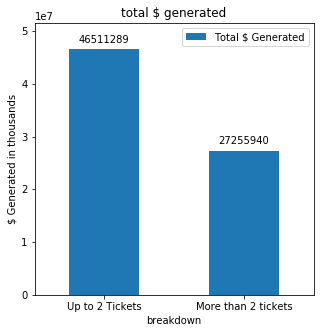

In [20]:
ax = df_for_graph.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("$ Generated in thousands")

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()

Text(0, 0.5, '')

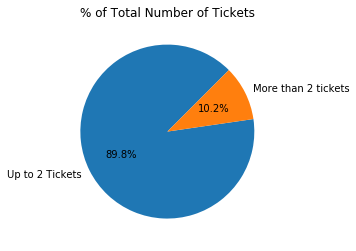

In [21]:
#pie chart

pie = breakdown_variable.plot(kind="pie", title="% of Total Number of Tickets", autopct="%1.1f%%", startangle=45)
pie.set_ylabel("")

Text(0, 0.5, '')

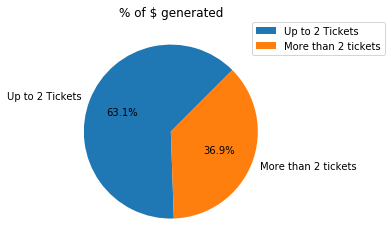

In [23]:
pie2 = violation_sum.plot(kind="pie", title="% of $ generated", autopct="%1.1f%%", startangle=45)
plt.legend(loc="upper left", bbox_to_anchor=(0.85,1.025))
pie2.set_ylabel("")

In [ ]:
# pies by state
#timeline of getting tickets
#top five flyers made $ vs 10,000 bottom others (do two buckets for visualization)


#Frequency of violations by state


# Total $ amount of violations by license plate
# Total $ amount of violations by state


In [ ]:
# Frequency of violations + Total fine amount by State

In [24]:
state_df = client_df[["state", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount", "summons_number"]]

state_df["Label"] = np.where(state_df["state"]=="NY","NY","Out of State")


state_grouping = state_df.groupby(["Label"])


C:\Users\jesus.baquiax\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
fine_amount_sum = state_grouping["fine_amount"].sum()
fine_amount_sum.head()

Label
NY              56976544
Out of State    16820865
Name: fine_amount, dtype: int64

In [26]:
state_frequency = state_grouping["summons_number"].count()
state_frequency.head()

Label
NY              788697
Out of State    211303
Name: summons_number, dtype: int64

In [27]:
state_combined_df = pd.DataFrame({"Total Violation Cost": fine_amount_sum, "Frequency": state_frequency})

state_fine_sort = state_combined_df.sort_values("Total Violation Cost", ascending=False)
state_fine_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,56976544,788697
Out of State,16820865,211303


In [28]:
state_frequency_sort = state_combined_df.sort_values("Frequency", ascending=False)
state_frequency_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,56976544,788697
Out of State,16820865,211303


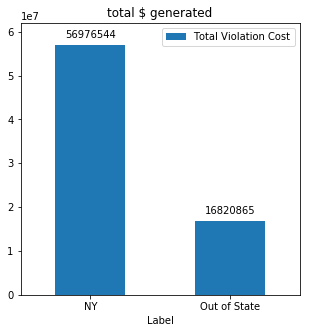

In [38]:
df_for_graph2 = pd.DataFrame({"Total Violation Cost": fine_amount_sum})

ay = df_for_graph2.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("")

for p in ay.patches: 
    ay.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph2["Total Violation Cost"])+ 5000000)

plt.show()

Text(0, 0.5, '')

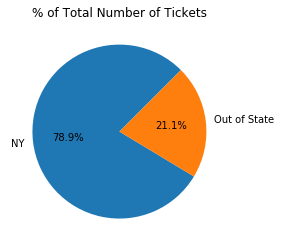

In [30]:
pie3 = state_frequency.plot(kind="pie", title="% of Total Number of Tickets", autopct="%1.1f%%", startangle=45)
pie3.set_ylabel("")

Text(0, 0.5, '')

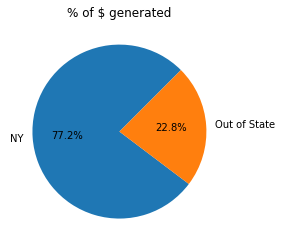

In [31]:
pie4 = fine_amount_sum.plot(kind="pie", title="% of $ generated", autopct="%1.1f%%", startangle=45)
pie4.set_ylabel("")